<a href="https://colab.research.google.com/github/VijayKumarBA/AI_AAT_assignment/blob/main/AI_AAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Dataset loaded successfully
  raw_label                                               text
0   neutral  Technopolis plans to develop in stages an area...
1  negative  The international electronic industry company ...
2  positive  With the new production plant the company woul...
3  positive  According to the company 's updated strategy f...
4  positive  FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...

Mapped label distribution:
label_text
Control             2878
Internal Control    1363
Potential Risk       604
Name: count, dtype: int64


Map:   0%|          | 0/3876 [00:00<?, ? examples/s]

Map:   0%|          | 0/969 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1027409214.py:149: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Starting training...



Epoch,Training Loss,Validation Loss,Accuracy
1,0.495100,0.423964,0.846233
2,0.273000,0.420559,0.853457
3,0.169000,0.542943,0.849329
4,0.093600,0.658592,0.867905
5,0.058000,0.755376,0.863777
6,0.053100,0.793086,0.871001
7,0.025800,0.826166,0.872033
8,0.007100,0.843336,0.874097
9,0.011900,0.821183,0.873065
10,0.018200,0.862087,0.876161



Evaluating model...



Classification Report:

                  precision    recall  f1-score   support

  Potential Risk     0.8492    0.8843    0.8664       121
         Control     0.9171    0.8837    0.9001       576
Internal Control     0.8090    0.8566    0.8321       272

        accuracy                         0.8762       969
       macro avg     0.8585    0.8749    0.8662       969
    weighted avg     0.8783    0.8762    0.8768       969



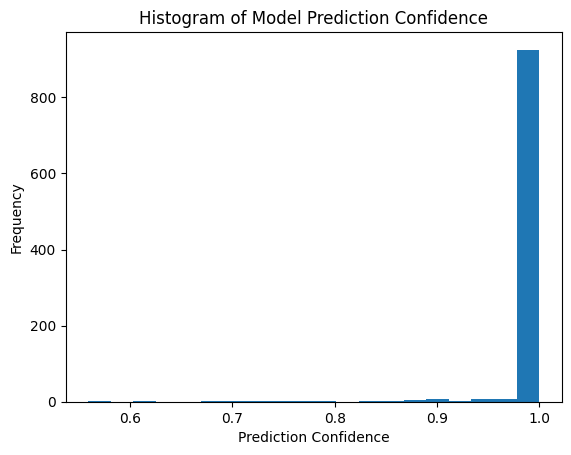

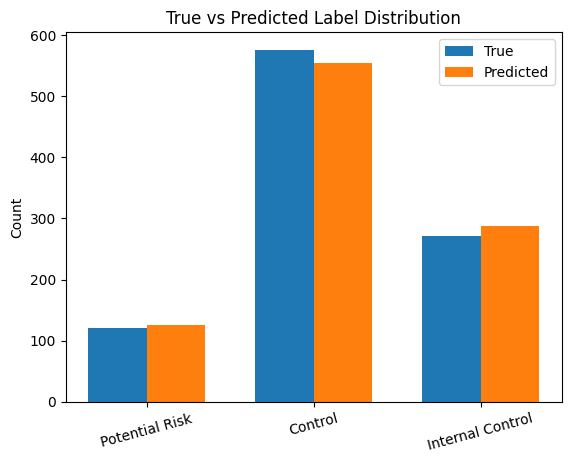

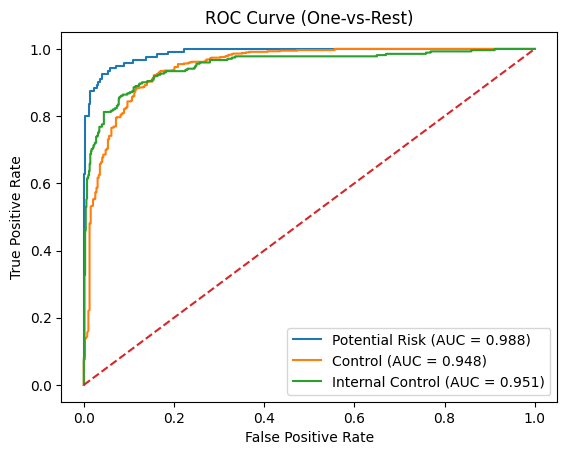

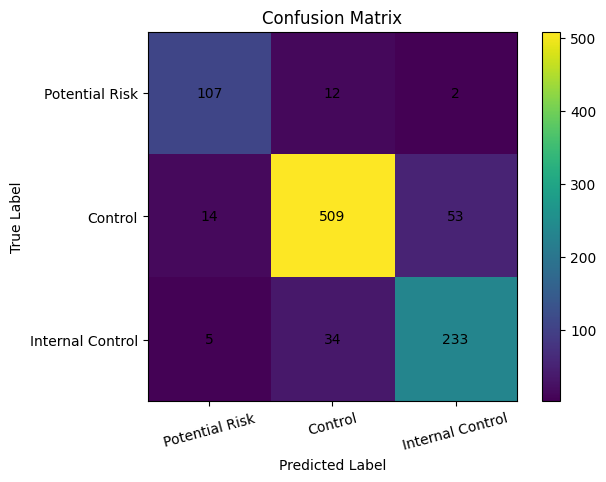

In [ ]:
import pandas as pd
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}


from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments
)

from datasets import Dataset

# =====================
# Reproducibility
# =====================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# =====================
# Load Dataset
# =====================
DATA_PATH = "/content/all-data.csv"

try:
    df = pd.read_csv(DATA_PATH, encoding="latin1")
    if df.shape[1] == 1:
        raise ValueError
    df.columns = ["raw_label", "text"]
except:
    df = pd.read_csv(DATA_PATH, sep=";", header=None, encoding="latin1")
    df.columns = ["raw_label", "text"]

print("\nDataset loaded successfully")
print(df.head())

# =====================
# Label Mapping
# =====================
label_map = {
    "negative": "Potential Risk",
    "neutral": "Control",
    "positive": "Internal Control"
}

df = df[df["raw_label"].isin(label_map)]
df["label_text"] = df["raw_label"].map(label_map)

label2id = {
    "Potential Risk": 0,
    "Control": 1,
    "Internal Control": 2
}
id2label = {v: k for k, v in label2id.items()}

df["label"] = df["label_text"].map(label2id)

print("\nMapped label distribution:")
print(df["label_text"].value_counts())

# =====================
# Text Cleaning
# =====================
def clean_text(text):
    text = str(text).replace("\n", " ")
    return " ".join(text.split())

df["text"] = df["text"].apply(clean_text)

# =====================
# Train / Test Split
# =====================
X_train, X_test, y_train, y_test = train_test_split(
    df["text"],
    df["label"],
    test_size=0.2,
    stratify=df["label"],
    random_state=SEED
)

# =====================
# Tokenization
# =====================
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

train_ds = Dataset.from_dict({"text": list(X_train), "label": list(y_train)})
test_ds = Dataset.from_dict({"text": list(X_test), "label": list(y_test)})

train_ds = train_ds.map(tokenize, batched=True)
test_ds = test_ds.map(tokenize, batched=True)

train_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# =====================
# Model
# =====================
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=3,
    id2label=id2label,
    label2id=label2id
)

# =====================
# Training Arguments
# =====================
training_args = TrainingArguments(
    output_dir="./bert-risk-output",
    eval_strategy="epoch", # Changed from evaluation_strategy
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    seed=SEED,
    logging_steps=100,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# =====================
# Train
# =====================
print("\nStarting training...\n")
trainer.train()

# =====================
# Evaluation
# =====================
print("\nEvaluating model...\n")
predictions = trainer.predict(test_ds)

y_pred = np.argmax(predictions.predictions, axis=1)
y_proba = torch.nn.functional.softmax(
    torch.tensor(predictions.predictions), dim=1
).numpy()

print("Classification Report:\n")
print(classification_report(
    y_test,
    y_pred,
    target_names=[id2label[i] for i in sorted(id2label)],
    digits=4
))

# =====================
# Visualization 1: Histogram
# =====================
plt.figure()
plt.hist(y_proba.max(axis=1), bins=20)
plt.xlabel("Prediction Confidence")
plt.ylabel("Frequency")
plt.title("Histogram of Model Prediction Confidence")
plt.show()

# =====================
# Visualization 2: Bar Graph
# =====================
true_counts = pd.Series(y_test).value_counts().sort_index()
pred_counts = pd.Series(y_pred).value_counts().sort_index()

labels = [id2label[i] for i in sorted(id2label)]
x = np.arange(len(labels))
width = 0.35

plt.figure()
plt.bar(x - width/2, true_counts, width, label="True")
plt.bar(x + width/2, pred_counts, width, label="Predicted")
plt.xticks(x, labels, rotation=15)
plt.ylabel("Count")
plt.title("True vs Predicted Label Distribution")
plt.legend()
plt.show()

# =====================
# Visualization 3: ROC Curve (One-vs-Rest)
# =====================
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

plt.figure()
for i in range(3):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{id2label[i]} (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (One-vs-Rest)")
plt.legend()
plt.show()

# =====================
# Visualization 4: Confusion Matrix (Box Form)
# =====================
cm = confusion_matrix(y_test, y_pred)

plt.figure()
plt.imshow(cm)
plt.xticks(range(3), labels, rotation=15)
plt.yticks(range(3), labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.colorbar()
plt.show()
